## Model Metrics

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl

from keras.models import Sequential, load_model
from keras.utils import to_categorical
from pathlib import Path

from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, LabelEncoder


DATA_DIR = (Path().parent / "../data").resolve()
DATA_DIR

WindowsPath('C:/Users/Michael/Downloads/Final-Year-Project/data')

In [2]:
MODEL: Sequential = load_model(DATA_DIR / "model.h5")

with open((DATA_DIR / "label_encoder.pkl"), "rb") as file:
    LBL_ENC: LabelEncoder = pkl.load(file)

In [3]:
raw_data: pd.DataFrame = pd.read_pickle(DATA_DIR / "dataset.pkl")
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   file_name  50 non-null     object  
 1   sign       50 non-null     category
 2   left       50 non-null     object  
 3   right      50 non-null     object  
 4   hand       50 non-null     category
dtypes: category(2), object(3)
memory usage: 1.5+ KB


In [4]:
def get_data(left: np.ndarray, right: np.ndarray, max_frames: int) -> np.ndarray:
    if (len(left) < max_frames):
        increment = [np.zeros(shape=441) for _ in range(max_frames - len(left))]
        temp_1 = np.concatenate((left, increment), axis=0)
        temp_2 = np.concatenate((right, increment), axis=0)
        result = np.stack((temp_1, temp_2), axis=0)

    else:
        result = np.stack((left, right), axis=0)

    return result

In [5]:
max_frames = max(len(item) for item in raw_data["left"])
print(f"Max Frame Count: {max_frames}")

X = np.array([
    get_data(raw_data.loc[x]["left"], raw_data.loc[x]["right"], max_frames)
    for x in range(len(raw_data))
])

X.shape

Max Frame Count: 78


(50, 2, 78, 441)

In [6]:
enc_labels = LBL_ENC.transform(raw_data["sign"])

Y = to_categorical(enc_labels)
Y.shape

(50, 5)

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [8]:
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=42, stratify=train_labels)

### Load Data

In [9]:
test_loss, test_acc = MODEL.evaluate(test_data, test_labels)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

1/1 [==============================] - 1s 558ms/step - loss: 2.0837 - accuracy: 0.7000
Test loss: 2.083707332611084
Test accuracy: 0.699999988079071


In [10]:
real = np.array([
    LBL_ENC.inverse_transform([np.argmax(item)])[0]
    for item in test_labels
])
real

array(['when', 'hello', 'okay', 'yes', 'yes', 'hello', 'no', 'okay', 'no',
       'when'], dtype='<U5')

In [11]:
raw_preds = MODEL.predict(test_data)

preds = np.array([
    LBL_ENC.inverse_transform([np.argmax(item)])[0]
    for item in raw_preds
])
preds

1/1 [==============================] - 0s 253ms/step


array(['when', 'hello', 'okay', 'yes', 'hello', 'yes', 'no', 'okay',
       'hello', 'when'], dtype='<U5')

In [12]:
labels = [LBL_ENC.inverse_transform([i])[0] for i in range(5)]
labels

['hello', 'no', 'okay', 'when', 'yes']

### Results

#### Confusion Matrix

In [13]:
# Create the Confusion Matrix
cm = confusion_matrix(y_true=real, y_pred=preds)
cm

array([[1, 0, 0, 0, 1],
       [1, 1, 0, 0, 0],
       [0, 0, 2, 0, 0],
       [0, 0, 0, 2, 0],
       [1, 0, 0, 0, 1]], dtype=int64)

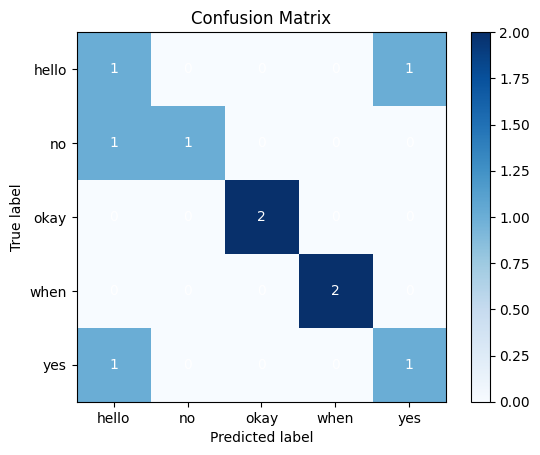

In [14]:
# Plot the Confusion Matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Add labels to the x-axis and y-axis.
ax.set_xticks(np.arange(len(cm)))
ax.set_yticks(np.arange(len(cm)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Add color bar.
cbar = ax.figure.colorbar(im, ax=ax)

# Loop over data and create annotations.
for i in range(len(cm)):
    for j in range(len(cm)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

# Add title and axis labels.
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

# Show the plot.
plt.show()

#### Classification Report

In [15]:
report = classification_report(y_true=real, y_pred=preds)
print(report)

              precision    recall  f1-score   support

       hello       0.33      0.50      0.40         2
          no       1.00      0.50      0.67         2
        okay       1.00      1.00      1.00         2
        when       1.00      1.00      1.00         2
         yes       0.50      0.50      0.50         2

    accuracy                           0.70        10
   macro avg       0.77      0.70      0.71        10
weighted avg       0.77      0.70      0.71        10



#### AUC/ROC Curve

##### Macro AUC/ROC Curve

In [16]:
# Binarizing True Labels
n_classes = 5
bin = label_binarize(test_labels, classes=np.arange(n_classes))

# Compute macro-average ROC curve and ROC area
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(bin[:, i], raw_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(n_classes):
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])

tpr_macro /= n_classes
roc_auc_macro = auc(fpr_macro, tpr_macro)
roc_auc_macro

0.8494949494949495

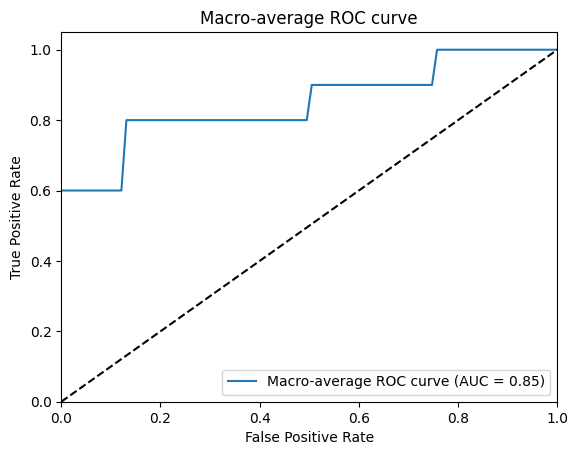

In [17]:
# Plot macro-average ROC curve
plt.figure()
plt.plot(fpr_macro, tpr_macro, label='Macro-average ROC curve (AUC = {0:0.2f})'.format(roc_auc_macro))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC curve')
plt.legend(loc="lower right")
plt.show()

##### Micro AUC/ROC Curve

In [18]:
# Binarizing True Labels
bin = label_binarize(test_labels, classes=np.arange(5))

# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(bin.ravel(), raw_preds.ravel())
roc_auc = auc(fpr, tpr)
roc_auc

0.8325

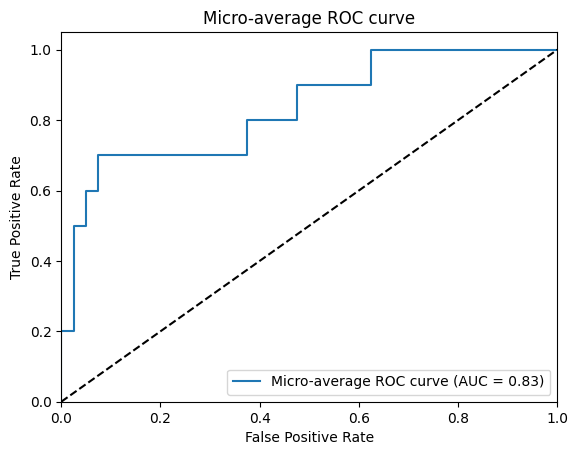

In [19]:
# Plot micro-average ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Micro-average ROC curve (AUC = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC curve')
plt.legend(loc="lower right")
plt.show()